Class distribution (label: count):
0 4825
1 747
Decision stump train accuracy: 0.8900605788647072
Decision stump test accuracy: 0.8860986547085202
Decision stump confusion matrix (test):
[[961   5]
 [122  27]]
Decision stump is weak on high-dimensional sparse text data because a single split cannot capture complex word patterns needed to separate spam from ham.
Iteration: 1
Misclassified indices: [   9   15   22   31   39   49   59   66   76   88   93  114  115  121
  123  159  162  166  174  194  203  214  216  224  229  261  300  302
  315  317  319  325  327  331  344  345  351  352  360  361  365  367
  370  371  376  389  404  412  415  419  421  458  459  461  501  516
  533  534  542  546  559  565  580  594  596  602  611  624  626  635
  640  679  681  687  690  701  710  716  717  725  732  742  745  750
  754  757  765  769  776  781  786  788  791  803  810  825  845  859
  870  871  884  913  916  922  925  927  928  930  978 1010 1016 1032
 1038 1042 1046 1072 1080 1090 1

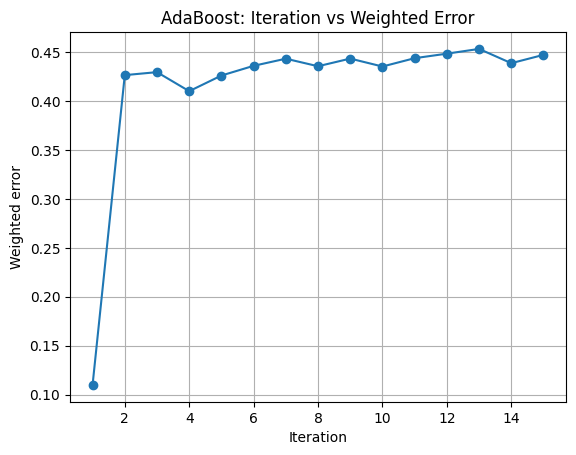

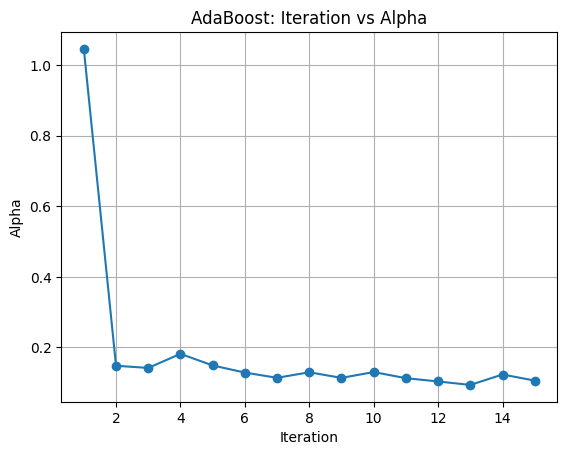

Manual AdaBoost train accuracy: 0.8916311420237828
Manual AdaBoost test accuracy: 0.8860986547085202
Manual AdaBoost confusion matrix (test):
[[961   5]
 [122  27]]
Top 10 sample indices with highest final weights: [3416 1911 3894  635  626 2757  611 3928  602  596]
Their labels: [1 1 1 1 1 1 1 1 1 1]
AdaBoost increases weights on hard-to-classify samples that are often misclassified across iterations.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Sklearn AdaBoost train accuracy: 0.903522548799641
Sklearn AdaBoost test accuracy: 0.905829596412556
Sklearn AdaBoost confusion matrix (test):
[[966   0]
 [105  44]]


In [1]:
import pandas as pd
import numpy as np
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt

df = pd.read_csv("/Users/anmol117/Downloads/spam-2.csv", encoding="latin-1")
if "label" in df.columns and "text" in df.columns:
    df = df[["label", "text"]]
elif "v1" in df.columns and "v2" in df.columns:
    df = df[["v1", "v2"]]
    df.columns = ["label", "text"]
df["label_num"] = df["label"].map({"ham": 0, "spam": 1})
df = df.dropna(subset=["text", "label_num"])

def clean_text(s):
    s = str(s).lower()
    s = s.translate(str.maketrans("", "", string.punctuation))
    return s

df["clean_text"] = df["text"].apply(clean_text)

vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(df["clean_text"])
y = df["label_num"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

unique, counts = np.unique(y, return_counts=True)
print("Class distribution (label: count):")
for u, c in zip(unique, counts):
    print(u, c)

stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)
y_train_pred = stump.predict(X_train)
y_test_pred = stump.predict(X_test)
print("Decision stump train accuracy:", accuracy_score(y_train, y_train_pred))
print("Decision stump test accuracy:", accuracy_score(y_test, y_test_pred))
print("Decision stump confusion matrix (test):")
print(confusion_matrix(y_test, y_test_pred))
print("Decision stump is weak on high-dimensional sparse text data because a single split cannot capture complex word patterns needed to separate spam from ham.")

T = 15
n_train = X_train.shape[0]
w = np.ones(n_train) / n_train
stumps = []
alphas = []
errors = []
y_train_signed = np.where(y_train == 1, 1, -1)

for t in range(T):
    stump_t = DecisionTreeClassifier(max_depth=1, random_state=42)
    stump_t.fit(X_train, y_train, sample_weight=w)
    pred_train = stump_t.predict(X_train)
    pred_signed = np.where(pred_train == 1, 1, -1)
    misclassified = pred_train != y_train
    err_t = np.dot(w, misclassified) / w.sum()
    if err_t == 0:
        err_t = 1e-10
    alpha_t = 0.5 * np.log((1 - err_t) / err_t)
    mis_idx = np.where(misclassified)[0]
    mis_w = w[misclassified].copy()
    print("Iteration:", t + 1)
    print("Misclassified indices:", mis_idx)
    print("Weights of misclassified samples:", mis_w)
    print("Alpha:", alpha_t)
    w = w * np.exp(-alpha_t * y_train_signed * pred_signed)
    w = w / w.sum()
    stumps.append(stump_t)
    alphas.append(alpha_t)
    errors.append(err_t)

iters = np.arange(1, len(errors) + 1)
plt.figure()
plt.plot(iters, errors, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Weighted error")
plt.title("AdaBoost: Iteration vs Weighted Error")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(iters, alphas, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Alpha")
plt.title("AdaBoost: Iteration vs Alpha")
plt.grid(True)
plt.show()

def ada_predict(X_data, stump_list, alpha_list):
    F = np.zeros(X_data.shape[0])
    for a, s in zip(alpha_list, stump_list):
        p = s.predict(X_data)
        p_signed = np.where(p == 1, 1, -1)
        F += a * p_signed
    y_signed = np.sign(F)
    y_pred = np.where(y_signed >= 0, 1, 0)
    return y_pred

train_pred_manual = ada_predict(X_train, stumps, alphas)
test_pred_manual = ada_predict(X_test, stumps, alphas)
manual_train_acc = accuracy_score(y_train, train_pred_manual)
manual_test_acc = accuracy_score(y_test, test_pred_manual)
print("Manual AdaBoost train accuracy:", manual_train_acc)
print("Manual AdaBoost test accuracy:", manual_test_acc)
print("Manual AdaBoost confusion matrix (test):")
print(confusion_matrix(y_test, test_pred_manual))
top_indices = np.argsort(-w)[:10]
print("Top 10 sample indices with highest final weights:", top_indices)
print("Their labels:", y_train[top_indices])
print("AdaBoost increases weights on hard-to-classify samples that are often misclassified across iterations.")

ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
    n_estimators=100,
    learning_rate=0.6,
    algorithm="SAMME.R"
)

ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
    n_estimators=100,
    learning_rate=0.6,
    algorithm="SAMME"
)
ada.fit(X_train, y_train)
train_pred_ada = ada.predict(X_train)
test_pred_ada = ada.predict(X_test)
print("Sklearn AdaBoost train accuracy:", accuracy_score(y_train, train_pred_ada))
print("Sklearn AdaBoost test accuracy:", accuracy_score(y_test, test_pred_ada))
print("Sklearn AdaBoost confusion matrix (test):")
print(confusion_matrix(y_test, test_pred_ada))



Decision stump train accuracy: 0.6818181818181818
Decision stump test accuracy: 0.6885245901639344
[[ 0 19]
 [ 0 42]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.69      1.00      0.82        42

    accuracy                           0.69        61
   macro avg       0.34      0.50      0.41        61
weighted avg       0.47      0.69      0.56        61

A decision stump struggles because heart disease prediction requires multiple interacting features.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

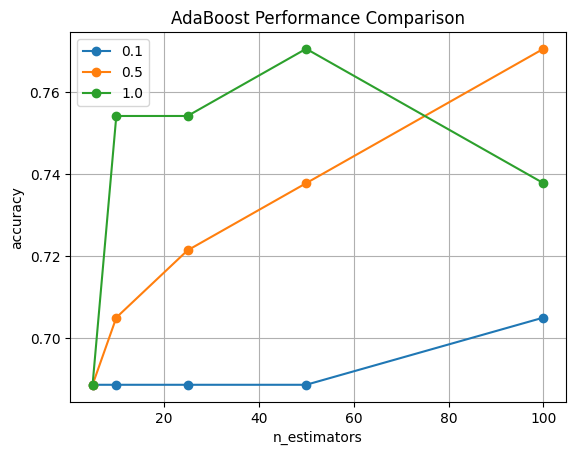

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


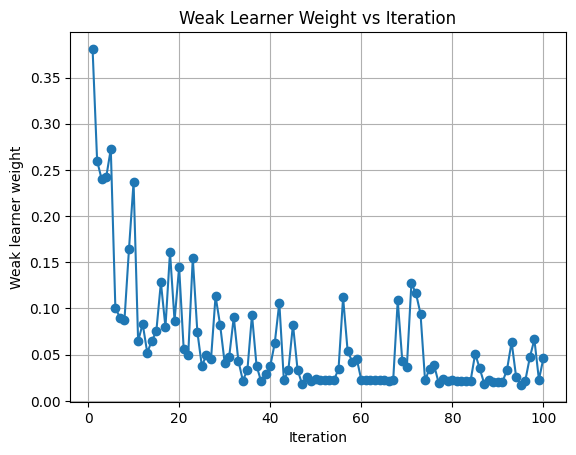

Top 5 Features:
thal       0.296005
thalach    0.223859
chol       0.155826
target     0.116979
ca         0.075055
dtype: float64
These features are dominant because they strongly relate to cardiovascular stress and heart functionality.


In [2]:
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt

heart = fetch_openml("Heart-Disease", version=1, as_frame=True)
df = heart.frame
df = df.dropna()

target_col = None
for col in df.columns:
    if df[col].nunique() == 2:
        target_col = col
        break

X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)
train_pred = stump.predict(X_train)
test_pred = stump.predict(X_test)
print("Decision stump train accuracy:", accuracy_score(y_train, train_pred))
print("Decision stump test accuracy:", accuracy_score(y_test, test_pred))
print(confusion_matrix(y_test, test_pred))
print(classification_report(y_test, test_pred))
print("A decision stump struggles because heart disease prediction requires multiple interacting features.")

estimators = [5, 10, 25, 50, 100]
lrates = [0.1, 0.5, 1.0]
results = {}

for lr in lrates:
    accs = []
    for est in estimators:
        model = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
            n_estimators=est,
            learning_rate=lr,
            algorithm="SAMME"
        )
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        accs.append(accuracy_score(y_test, pred))
    results[lr] = accs

for lr in lrates:
    plt.plot(estimators, results[lr], marker="o", label=str(lr))
plt.xlabel("n_estimators")
plt.ylabel("accuracy")
plt.title("AdaBoost Performance Comparison")
plt.legend()
plt.grid(True)
plt.show()

best_lr = None
best_est = None
best_acc = -1
for lr in lrates:
    for idx, est in enumerate(estimators):
        if results[lr][idx] > best_acc:
            best_acc = results[lr][idx]
            best_lr = lr
            best_est = est

best_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
    n_estimators=best_est,
    learning_rate=best_lr,
    algorithm="SAMME"
)
best_model.fit(X_train, y_train)

weights = best_model.estimator_weights_
plt.plot(range(1, len(weights) + 1), weights, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Weak learner weight")
plt.title("Weak Learner Weight vs Iteration")
plt.grid(True)
plt.show()

feat = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top 5 Features:")
print(feat.head(5))
print("These features are dominant because they strongly relate to cardiovascular stress and heart functionality.")


Stump train accuracy: 0.6521258341277407
Stump test accuracy: 0.6519021905872247
[[170673  17473]
 [ 95986  41808]]
Iteration: 1
Misclassified indices: [     0      2      3 ... 760520 760522 760523]
Misclassified weights: [1.31488117e-06 1.31488117e-06 1.31488117e-06 ... 1.31488117e-06
 1.31488117e-06 1.31488117e-06]
Alpha: 0.3141983591852244
Iteration: 2
Misclassified indices: [     0      1      2 ... 760520 760522 760523]
Misclassified weights: [1.88988045e-06 1.00814988e-06 1.88988045e-06 ... 1.88988045e-06
 1.88988045e-06 1.88988045e-06]
Alpha: 0.07031298650448499
Iteration: 3
Misclassified indices: [     4      7      9 ... 760519 760521 760524]
Misclassified weights: [9.42022415e-07 1.76591772e-06 9.42022415e-07 ... 9.42022415e-07
 9.42022415e-07 9.42022415e-07]
Alpha: 0.10262646918777878
Iteration: 4
Misclassified indices: [     0      1      2 ... 760518 760520 760523]
Misclassified weights: [1.84398113e-06 9.83665058e-07 1.84398113e-06 ... 1.84398113e-06
 1.84398113e-06 1.84

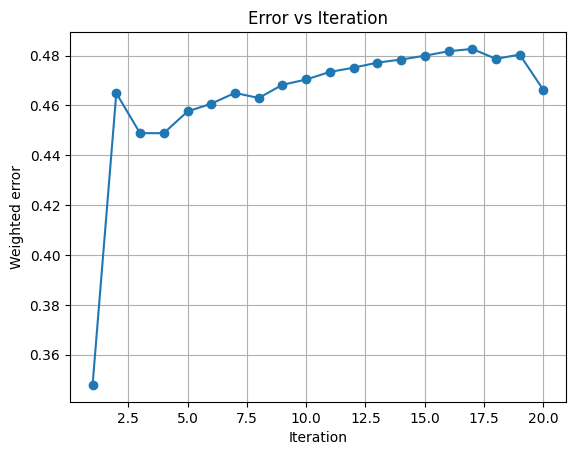

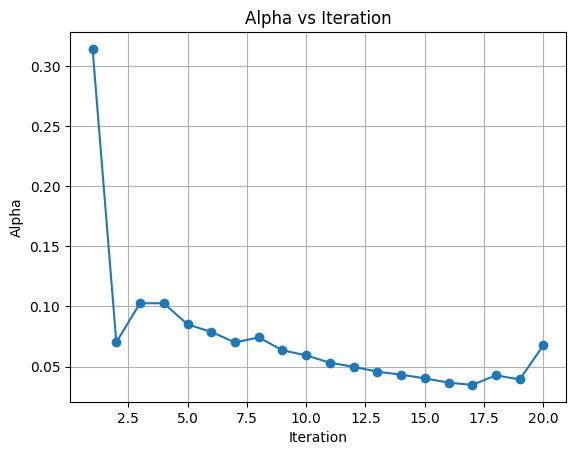

Manual AdaBoost train accuracy: 0.696132277045462
Manual AdaBoost test accuracy: 0.69539792599865
[[164614  23532]
 [ 75750  62044]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Sklearn AdaBoost train accuracy: 0.6976115183590283
Sklearn AdaBoost test accuracy: 0.6969166104190956
[[164210  23936]
 [ 74851  62943]]


In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt

df = pd.read_csv("/Users/anmol117/Downloads/WISDM_ar_v1.1_raw.txt", header=None, on_bad_lines='skip')
df.columns = ["user","activity","timestamp","x","y","z"]

df["z"] = df["z"].astype(str).str.replace(";", "", regex=False)

df["x"] = pd.to_numeric(df["x"], errors='coerce')
df["y"] = pd.to_numeric(df["y"], errors='coerce')
df["z"] = pd.to_numeric(df["z"], errors='coerce')

df = df.dropna(subset=["x","y","z"])   # ← THIS FIXES YOUR ERROR

vigorous = ["Jogging","Upstairs"]
df["label"] = df["activity"].apply(lambda x: 1 if x in vigorous else 0)

X = df[["x","y","z"]]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)
train_pred = stump.predict(X_train)
test_pred = stump.predict(X_test)
print("Stump train accuracy:", accuracy_score(y_train, train_pred))
print("Stump test accuracy:", accuracy_score(y_test, test_pred))
print(confusion_matrix(y_test, test_pred))

T = 20
w = np.ones(len(X_train), dtype=float) / len(X_train)
w = np.array(w, dtype=float)  # <- hard force to numpy

models = []
alphas = []
errors = []

for t in range(T):
    w = np.array(w, dtype=float)  # <- ensures it's ALWAYS numpy
    m = DecisionTreeClassifier(max_depth=1, random_state=42)
    m.fit(X_train, y_train, sample_weight=w)

    pred = m.predict(X_train)
    mis = pred != y_train
    mis = np.array(mis, dtype=bool)  # <- force numpy mask

    idx = np.where(mis)[0]  # integer positions
    err = np.dot(w, mis)

    if err == 0:
        err = 1e-10

    alpha = 0.5 * np.log((1 - err) / err)

    print("Iteration:", t+1)
    print("Misclassified indices:", idx)
    print("Misclassified weights:", w[idx])  # <-- NOW SAFE
    print("Alpha:", alpha)

    w = w * np.exp(alpha * (mis * 2 - 1))
    w = w / w.sum()

    models.append(m)
    alphas.append(alpha)
    errors.append(err)

plt.plot(range(1,T+1), errors, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Weighted error")
plt.title("Error vs Iteration")
plt.grid(True)
plt.show()

plt.plot(range(1,T+1), alphas, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Alpha")
plt.title("Alpha vs Iteration")
plt.grid(True)
plt.show()

def ada_pred(X, ms, al):
    F = np.zeros(X.shape[0])
    for a,m in zip(al,ms):
        p = m.predict(X)
        p = np.where(p==1,1,-1)
        F += a*p
    return np.where(F>=0,1,0)

train_manual = ada_pred(X_train, models, alphas)
test_manual = ada_pred(X_test, models, alphas)
print("Manual AdaBoost train accuracy:", accuracy_score(y_train, train_manual))
print("Manual AdaBoost test accuracy:", accuracy_score(y_test, test_manual))
print(confusion_matrix(y_test, test_manual))

ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
    n_estimators=100,
    learning_rate=1.0,
    algorithm="SAMME"
)
ada.fit(X_train, y_train)
p_train = ada.predict(X_train)
p_test = ada.predict(X_test)
print("Sklearn AdaBoost train accuracy:", accuracy_score(y_train, p_train))
print("Sklearn AdaBoost test accuracy:", accuracy_score(y_test, p_test))
print(confusion_matrix(y_test, p_test))
